In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import data_utils.data_analysis as data_analysis

# Load dataset

In [2]:
filename='datasets/galadriel_dataset_24_09_18_high_res.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
      shot number   order2   order3     order4  goodness
0          163165  34400.0 -23000.0 -5500000.0  0.945039
1          163166  34400.0 -23000.0 -5500000.0  0.862834
2          163167  34400.0 -23000.0 -5500000.0  0.834347
3          163168  34400.0 -23000.0 -5500000.0  0.873099
4          163169  34400.0 -23000.0 -5500000.0  0.851336
...           ...      ...      ...        ...       ...
9498       172664  35400.0  28000.0 -4000000.0  1.031447
9499       172665  35400.0  28000.0 -4000000.0  1.031718
9500       172666  35400.0  28000.0 -4000000.0  1.009015
9501       172667  35400.0  28000.0 -4000000.0  1.199801
9502       172668  35400.0  28000.0 -4000000.0  1.241150

[9503 rows x 5 columns]
----
Time values
0    -104.962227
1     -94.466005
2     -83.969782
3     -73.473559
4     -62.977336
5     -52.481114
6     -41.984891
7     -31.488668
8     -20.992445
9     -10.496223
10      0.000000
11     10.496223
12     20.992445
13     31.488668
14     41.984891
15     52.

In [3]:
df_spec_freq=pd.read_hdf(filename,'df_spec_freq')
df_spec_int=pd.read_hdf(filename,'df_spec_int')
df_spec_phase=pd.read_hdf(filename,'df_spec_phase')

### Pulse reconstruction

In [4]:
#time in fs (it is the boundary)
#using DASK to accelerate computing
def pulse_reconst_dask(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = delayed(pulse.pulse)(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        #p_list.append(p.intensity)
        p_list.append(p)
    p_list=compute(p_list)[0]
    p_int=[p.intensity for p in p_list]
    return t,pd.DataFrame(p_int)
    #return t,p_int

In [5]:
#time in fs (it is the boundary)
def pulse_reconst_old(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)

In [6]:
filename_pulse='datasets/pulse_240918.h5'

In [7]:
#read the data
#df_time_50=pd.read_hdf(filename_pulse,'df_time_50',mode='r')
#df_pulse_50=pd.read_hdf(filename_pulse,'df_pulse_50')
#t_50=df_time_50.to_numpy()

df_time_200=pd.read_hdf(filename_pulse,'df_time_200')
df_pulse_200=pd.read_hdf(filename_pulse,'df_pulse_200')
t_200=df_time_200.to_numpy()

### Drop shots whith bad goodness

In [8]:
df_input_reduced=df_input[df_input['goodness']>1.3]

good_shots_list=df_input_reduced.index.values
#print(good_shots_list)
df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_pulse_200_reduced.reset_index(inplace=True,drop=True)

# Fitting

In [9]:
## Fit a curve to given (x,y) data
def fitting(x,y,p0):
    popt, pcov = curve_fit(func, x, y,p0,maxfev=20000)
    return popt

#define the curve to fit
def func(t,a0, a1,a2,
        b0,b1,b2,
        c0,c1,c2,
        d0,d1,d2,
        e0,e1,e2): 
    #envelope=1*np.exp(-((t-0)**2)/(2*30*30))
    return (a0*np.exp(-((t-a1)**2)/(2*a2*a2))
            +b0*np.exp(-((t-b1)**2)/(2*b2*b2))
           +c0*np.exp(-((t-c1)**2)/(2*c2*c2))
           +d0*np.exp(-((t-d1)**2)/(2*d2*d2))
           +e0*np.exp(-((t-e1)**2)/(2*e2*e2)))

In [10]:
test_pulse=df_pulse_200_reduced.iloc[857].values

In [11]:
p0=[0.05,-80,1,
   0.05,-60,3,
   1,0,10,
   0,50,3,
   0.05,80,1]#initial guess
popt=fitting(t_200,test_pulse,p0)

In [12]:
fitted=func(t_200,*popt)
error=abs(test_pulse-fitted)
error=error.sum()/len(test_pulse)
print(100*error)

0.13656300292440723


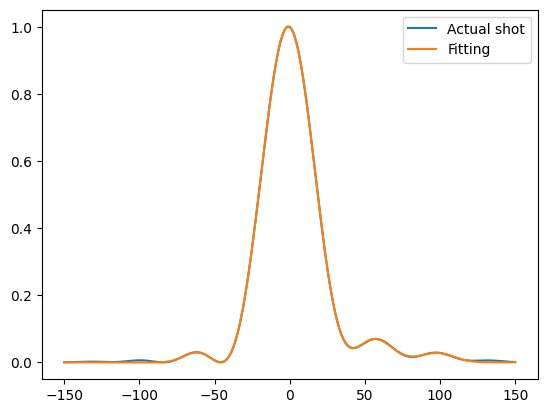

In [13]:
plt.plot(t_200,test_pulse,label='Actual shot')
plt.plot(t_200,fitted,label='Fitting')
plt.legend()

In [14]:
%%time
p0=[0.05,-80,1,
   0.05,-60,3,
   1,0,10,
   0,50,3,
   0.05,80,1]#initial guess

param_list=[]
error_list=[]
excep_counter=0
#for index, row in df_pulse_200_reduced[0:150].iterrows():
for index, row in df_pulse_200_reduced.iterrows():
    try:
        popt=fitting(t_200,row.values,p0)
        param_list.append(popt)
        #calc error
        fitted=func(t_200,*popt)
        error=abs(row.values-fitted)
        error=error.sum()/len(fitted)
        error_list.append(error)
    except:
        excep_counter+=1

df_fit_param=pd.DataFrame(param_list,columns=['amp1','mean1','sigma1','amp2','mean2','sigma2','amp3','mean3','sigma3','amp4','mean4','sigma4','amp5','mean5','sigma5'])
df_fit_param['error fit']=pd.DataFrame(error_list)
print(df_fit_param)


print(excep_counter,'shots couldnt be fitted')


/tmp/ipykernel_10836/3065801033.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x, y,p0,maxfev=20000)


          amp1      mean1     sigma1      amp2      mean2     sigma2  \
0    -0.022392 -72.896144   5.708922  0.016064 -57.765888   2.530160   
1     0.085223 -60.722525  -9.158643  0.276493 -21.803040  10.866179   
2    -0.000349 -85.050481  -0.014689  0.133488 -26.076831  25.862265   
3     0.019578 -88.628827   9.069974  0.133488 -55.652314   7.266011   
4     0.026807 -82.932824 -73.985572  0.676625  -3.679286   8.492963   
...        ...        ...        ...       ...        ...        ...   
2435  0.047624 -34.541960  20.217182  0.665691 -10.860635  11.827900   
2436  0.033691 -42.851137  21.760571  0.622970 -12.707411  12.465915   
2437  0.047180 -38.205633  21.357811  0.603875 -11.617201  12.144179   
2438  0.044537 -34.047113  20.015081  0.678572 -10.541534  11.726819   
2439  0.035733 -41.454608 -21.419147  0.700475 -11.443092  12.039291   

          amp3      mean3     sigma3      amp4      mean4    sigma4      amp5  \
0     0.869522  16.195842  33.766096 -0.541899  40.916

In [15]:
df_fit_param=df_fit_param[df_fit_param['mean1']>-200]
df_fit_param=df_fit_param[df_fit_param['mean2']>-200]
df_fit_param=df_fit_param[df_fit_param['mean3']<200]
df_fit_param=df_fit_param[df_fit_param['mean4']<200]
df_fit_param=df_fit_param[df_fit_param['mean5']<200]

#avoid larger values
df_fit_param=df_fit_param[df_fit_param<1000]

#ampl
df_fit_param=df_fit_param[df_fit_param['amp1']>0]
df_fit_param=df_fit_param[df_fit_param['amp2']>0]
df_fit_param=df_fit_param[df_fit_param['amp3']>0]
df_fit_param=df_fit_param[df_fit_param['amp4']>0]
df_fit_param=df_fit_param[df_fit_param['amp5']>0]

In [16]:
#Enforce sigma is positive
df_fit_param['sigma1']=df_fit_param['sigma1'].apply(np.abs)
df_fit_param['sigma2']=df_fit_param['sigma2'].apply(np.abs)
df_fit_param['sigma3']=df_fit_param['sigma3'].apply(np.abs)
df_fit_param['sigma4']=df_fit_param['sigma4'].apply(np.abs)
df_fit_param['sigma5']=df_fit_param['sigma5'].apply(np.abs)

In [17]:
#show nan values
df_fit_param[df_fit_param.isna().any(axis=1)]

,amp1,mean1,sigma1,amp2,mean2,sigma2,amp3,mean3,sigma3,amp4,mean4,sigma4,amp5,mean5,sigma5,error fit


In [18]:
#drop nan rows
df_fit_param=df_fit_param.dropna()

In [19]:
df_fit_param.describe()

,amp1,mean1,sigma1,amp2,mean2,sigma2,amp3,mean3,sigma3,amp4,mean4,sigma4,amp5,mean5,sigma5,error fit
count,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000,2022.000000
mean,0.048232,-77.960575,12.985858,0.119159,-50.731147,7.917552,0.909607,-2.624621,12.549440,0.092173,44.850201,7.035316,0.044222,75.121953,16.992027,0.005415
std,0.126264,30.010694,9.065835,0.189323,18.571884,4.618496,0.220168,4.767073,2.237258,0.124892,10.439976,2.303511,0.109965,19.674110,8.925947,0.003079
min,0.000077,-195.154003,0.000926,0.000191,-143.593443,0.004520,0.115062,-21.020310,4.777134,0.000015,-10.040546,0.014517,0.000021,-80.042805,0.002918,0.000617
25%,0.007162,-93.916803,6.881464,0.032209,-61.514563,5.718363,0.983689,-5.466300,11.343074,0.033219,41.884465,5.615825,0.009973,70.261446,10.980101,0.003766
50%,0.013877,-87.206909,10.843449,0.053279,-56.220499,6.759411,1.008177,-2.686510,12.941720,0.061749,45.780534,7.033075,0.023917,76.690678,15.813340,0.004926
75%,0.028563,-69.512858,14.582962,0.092902,-50.233455,8.162202,1.014466,-0.072605,14.077615,0.099167,50.021214,7.993768,0.038061,85.955021,20.257768,0.006171
max,0.910617,382.650393,73.427442,0.911118,131.691972,81.712813,1.058114,14.178193,23.592112,0.921232,73.468537,36.657819,0.932960,198.572204,83.496203,0.050116


Text(0, 0.5, '# shots')

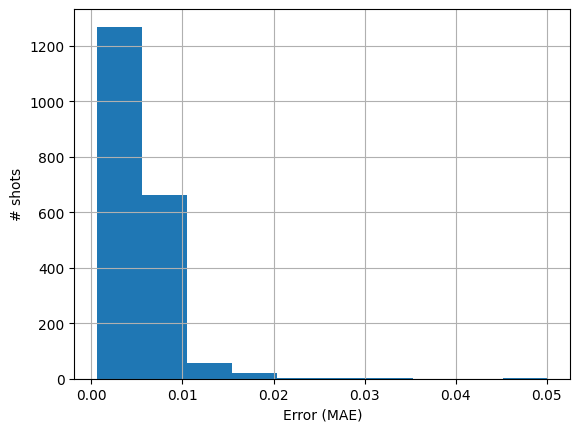

In [20]:
df_fit_param['error fit'].hist()
plt.xlabel('Error (MAE)')
plt.ylabel('# shots')

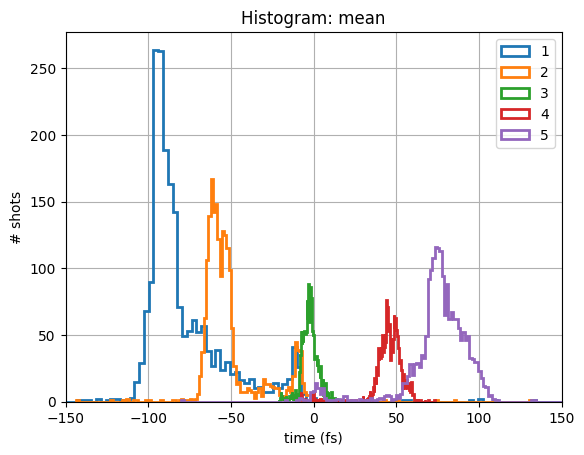

In [21]:
#df_plot=pd.DataFrame({'Mean1':df_fit_param['mean1'],'Mean2':df_fit_param['mean2'],
#                      'Mean3':df_fit_param['mean3'],
#                      'Mean4':df_fit_param['mean4'],
#                     'Mean5':df_fit_param['mean5']})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
#print(df_plot)
#sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.1,split=True,orient='h')
#sns.boxplot(data=df_plot,orient='h')
df_fit_param['mean1'].hist(histtype='step',bins=200,linewidth=2,label='1')
df_fit_param['mean2'].hist(histtype='step',bins=200,linewidth=2,label='2')
df_fit_param['mean3'].hist(histtype='step',bins=100,linewidth=2,label='3')
df_fit_param['mean4'].hist(histtype='step',bins=200,linewidth=2,label='4')
df_fit_param['mean5'].hist(histtype='step',bins=200,linewidth=2,label='5')
plt.xlabel('time (fs)')
plt.ylabel('# shots')
plt.title('Histogram: mean')
plt.xlim(-150,150)
plt.legend()

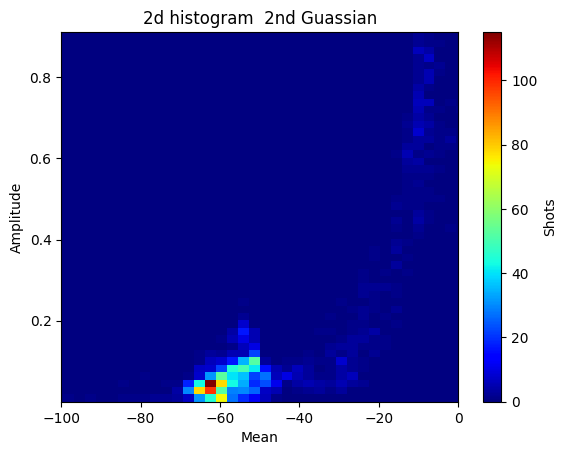

In [22]:
fig, ax = plt.subplots()
plt.hist2d(df_fit_param['mean2'], df_fit_param['amp2'],bins=(100, 50),cmap='jet')
ax.set_xlabel('Mean')
ax.set_ylabel('Amplitude')
ax.set_xlim(-100,0)
#ax.set_ylim(0,1)
plt.title('2d histogram  2nd Guassian')
#cbar =fig.colorbar(h1, ax=ax)
cbar=plt.colorbar()
cbar.set_label('Shots')
#plt.legend()

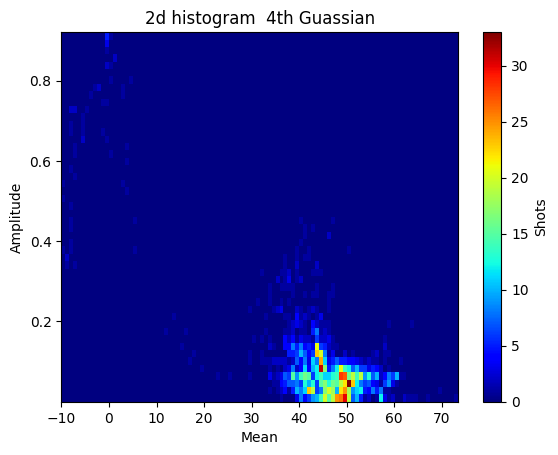

In [23]:
fig, ax = plt.subplots()
plt.hist2d(df_fit_param['mean4'], df_fit_param['amp4'],bins=(100, 50),cmap='jet')
ax.set_xlabel('Mean')
ax.set_ylabel('Amplitude')
#ax.set_xlim(-100,0)
#ax.set_ylim(0,1)
plt.title('2d histogram  4th Guassian')
#cbar =fig.colorbar(h1, ax=ax)
cbar=plt.colorbar()
cbar.set_label('Shots')
#plt.legend()

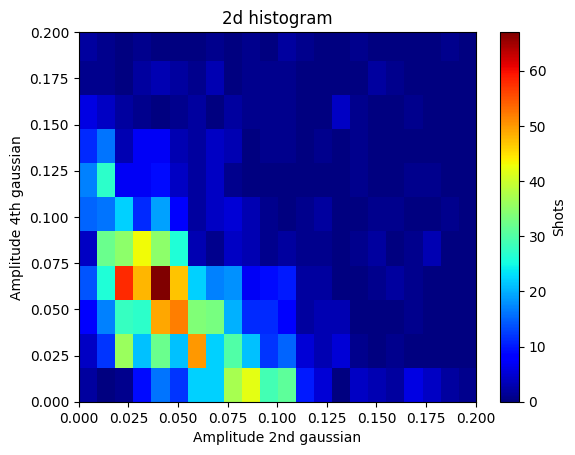

In [24]:
fig, ax = plt.subplots()
plt.hist2d(df_fit_param['amp2'], df_fit_param['amp4'],bins=(100, 50),cmap='jet')
ax.set_xlabel('Amplitude 2nd gaussian')
ax.set_ylabel('Amplitude 4th gaussian')
ax.set_xlim(0,0.2)
ax.set_ylim(0,0.2)
plt.title('2d histogram')
#cbar =fig.colorbar(h1, ax=ax)
cbar=plt.colorbar()
cbar.set_label('Shots')
#plt.legend()

          Amp1      Amp2      Amp3      Amp4      Amp5
1     0.085223  0.276493  1.009644  0.019235  0.041124
3     0.019578  0.133488  0.964378  0.019815  0.006363
5     0.028334  0.038526  0.512390  0.626874  0.001774
6     0.032921  0.029157  0.697990  0.455060  0.000109
7     0.037556  0.134165  1.010145  0.046978  0.007823
...        ...       ...       ...       ...       ...
2435  0.047624  0.665691  0.519432  0.123488  0.021801
2436  0.033691  0.622970  0.593535  0.135259  0.023030
2437  0.047180  0.603875  0.583019  0.124251  0.023119
2438  0.044537  0.678572  0.503838  0.123756  0.024968
2439  0.035733  0.700475  0.501288  0.119656  0.021335

[2022 rows x 5 columns]


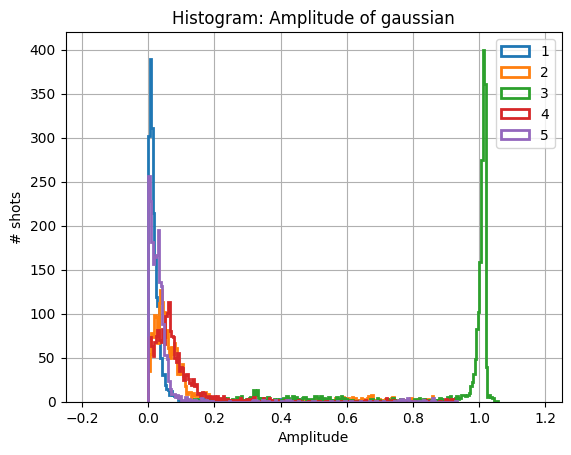

In [32]:
df_plot=pd.DataFrame({'Amp1':df_fit_param['amp1'],'Amp2':df_fit_param['amp2'],
                      'Amp3':df_fit_param['amp3'],
                      'Amp4':df_fit_param['amp4'],
                     'Amp5':df_fit_param['amp5']})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
print(df_plot)
#sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.1,split=True,orient='h')
#sns.boxplot(data=df_plot,orient='h')
df_fit_param['amp1'].hist(histtype='step',bins=200,linewidth=2,label='1')
df_fit_param['amp2'].hist(histtype='step',bins=200,linewidth=2,label='2')
df_fit_param['amp3'].hist(histtype='step',bins=200,linewidth=2,label='3')
df_fit_param['amp4'].hist(histtype='step',bins=200,linewidth=2,label='4')
df_fit_param['amp5'].hist(histtype='step',bins=200,linewidth=2,label='5')
plt.xlabel('Amplitude')
plt.ylabel('# shots')
plt.title('Histogram: Amplitude of gaussian')
plt.xlim(-0.25,1.25)
plt.legend()

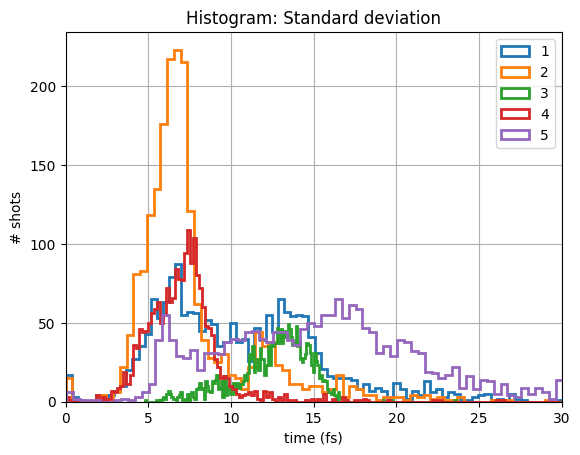

In [26]:
#df_plot=pd.DataFrame({'Sigma1':df_fit_param['sigma1'],'Mean2':df_fit_param['sigma2'],
#                      'Sigma3':df_fit_param['sigma3'],
#                      'Sigma4':df_fit_param['sigma4'],
#                     'Sigma5':df_fit_param['sigma5']})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
#print(df_plot)
#sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.1,split=True,orient='h')
#sns.boxplot(data=df_plot,orient='h')
df_fit_param['sigma1'].hist(histtype='step',bins=200,linewidth=2,label='1')
df_fit_param['sigma2'].hist(histtype='step',bins=200,linewidth=2,label='2')
df_fit_param['sigma3'].hist(histtype='step',bins=200,linewidth=2,label='3')
df_fit_param['sigma4'].hist(histtype='step',bins=200,linewidth=2,label='4')
df_fit_param['sigma5'].hist(histtype='step',bins=200,linewidth=2,label='5')
plt.xlabel('time (fs)')
plt.ylabel('# shots')
plt.title('Histogram: Standard deviation')
plt.xlim(0,30)
plt.legend()

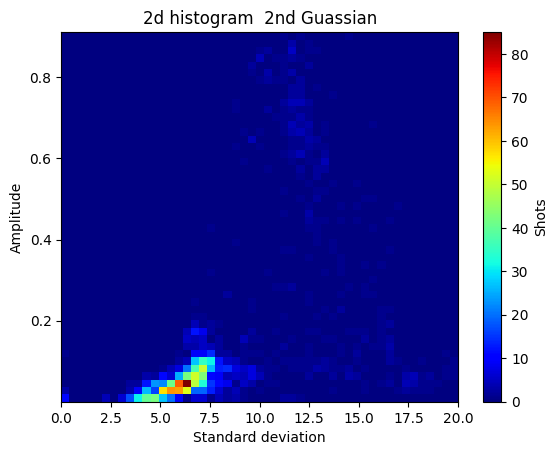

In [27]:
fig, ax = plt.subplots()
plt.hist2d(df_fit_param['sigma2'], df_fit_param['amp2'],bins=(200, 50),cmap='jet')
ax.set_xlabel('Standard deviation')
ax.set_ylabel('Amplitude')
ax.set_xlim(0,20)
#ax.set_ylim(0,1)
plt.title('2d histogram  2nd Guassian')
#cbar =fig.colorbar(h1, ax=ax)
cbar=plt.colorbar()
cbar.set_label('Shots')
#plt.legend()

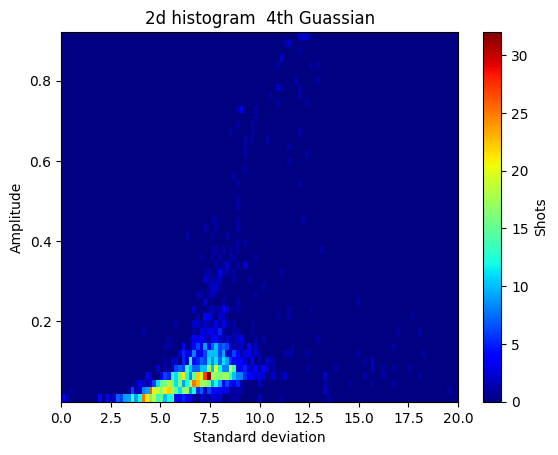

In [28]:
fig, ax = plt.subplots()
plt.hist2d(df_fit_param['sigma4'], df_fit_param['amp4'],bins=(200, 50),cmap='jet')
ax.set_xlabel('Standard deviation')
ax.set_ylabel('Amplitude')
ax.set_xlim(0,20)
#ax.set_ylim(0,1)
plt.title('2d histogram  4th Guassian')
#cbar =fig.colorbar(h1, ax=ax)
cbar=plt.colorbar()
cbar.set_label('Shots')
#plt.legend()

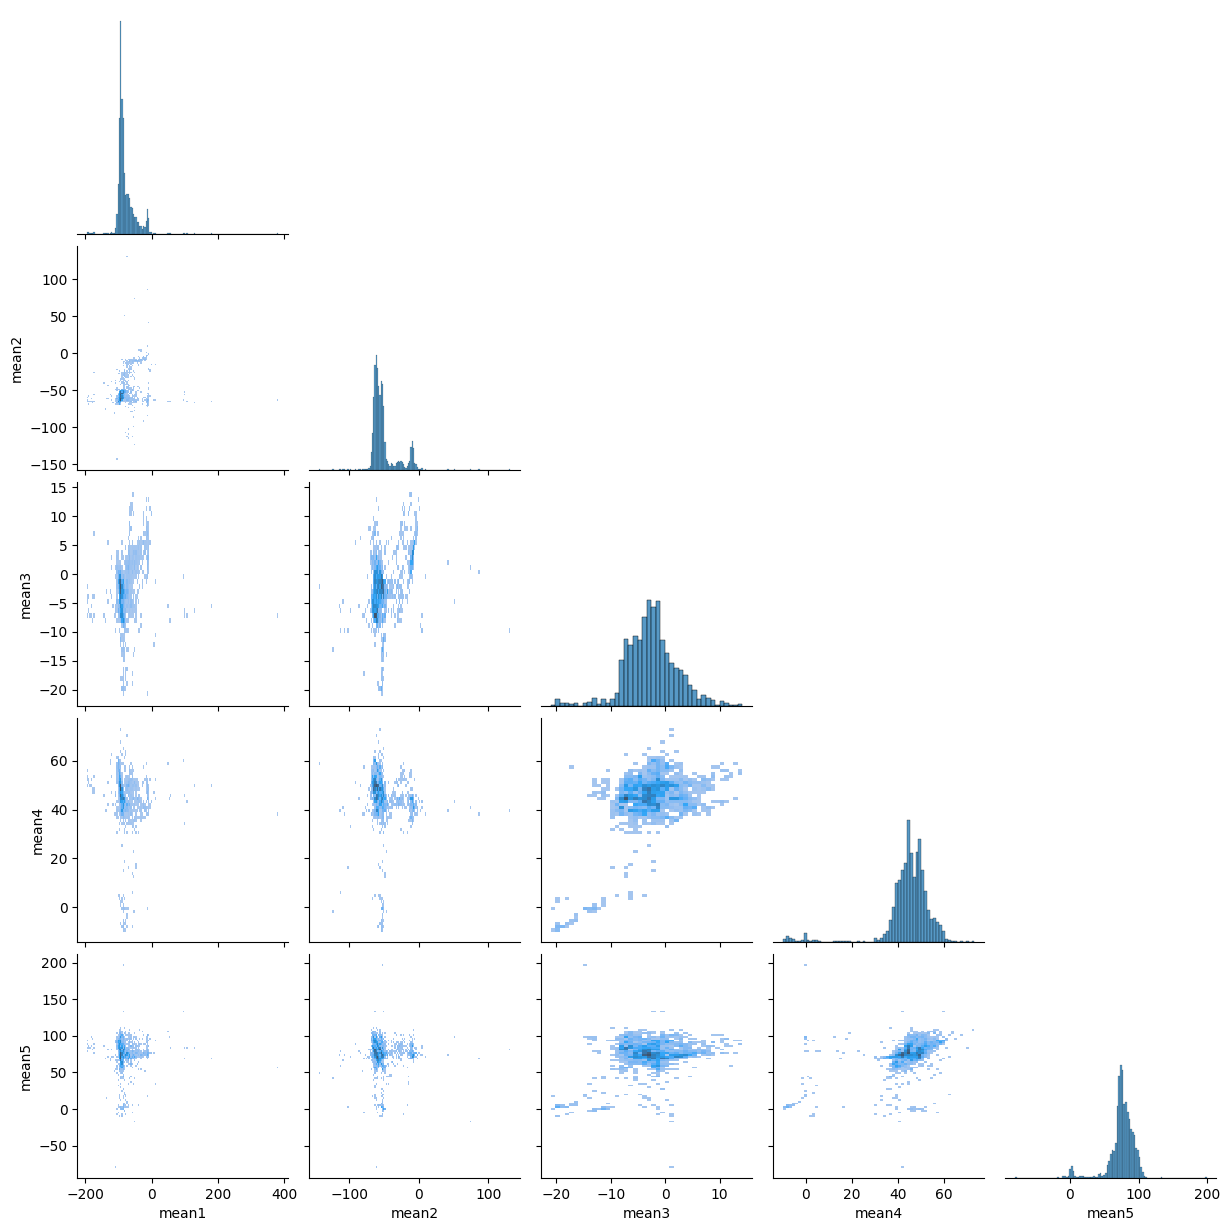

In [29]:
sns.pairplot(df_fit_param[['mean1','mean2','mean3','mean4','mean5']],kind='hist',corner=True)

In [36]:
df_input[995:1010]

,shot number,order2,order3,order4,goodness
995,164160,34500.0,-17000.0,-4300000.0,1.296293
996,164161,34500.0,-17000.0,-4300000.0,1.295503
997,164162,34500.0,-17000.0,-4300000.0,1.291729
998,164163,34500.0,-17000.0,-4300000.0,1.329183
999,164164,34500.0,-17000.0,-4300000.0,1.315941
1000,164165,34500.0,-17000.0,-4000000.0,1.215616
1001,164166,34500.0,-17000.0,-4000000.0,1.247866
1002,164167,34500.0,-17000.0,-4000000.0,1.205874
1003,164168,34500.0,-17000.0,-4000000.0,1.206952
1004,164169,34500.0,-17000.0,-4000000.0,1.208166
